## Import Libraries

In [2]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
#import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled


## Import data and holdout data for prediction

In [18]:
import pickle
with open(os.path.abspath(os.path.join('../..', 'oumaima/encoded_labels'))+'/technical_team.pkl', 'rb') as handle:
    df = pickle.load(handle)
    
df

,PIMS_ID,all_text,Chemicals_and_Waste_Programme,Climate_Change_Adaptation_Programme,Climate_Change_Mitigation_Programme,Climate_Strategies_and_Policy_Programme,Ecosystems_and_Biodiversity_Programme,Energy_Program_of_Climate_Change_Mitigation,Oceans_and_Water_Programme
0,1584,This programme will contribute to the protecti...,0,0,0,0,1,0,0
1,1878,The project contributes to the number of GEF p...,0,0,0,0,1,0,0
2,2006,The Cape Floristic Region (CFR) Biodiversity H...,0,0,0,0,1,0,0
3,2047,"The Niger Delta region of Nigeria, covering an...",0,0,0,0,1,0,0
4,2204,The Government of South Africa has developed t...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
580,4000,The GEF co-financed project will comprise thre...,0,0,0,0,1,0,0
581,4186,The project aims to develop and institutionali...,0,0,0,0,1,0,0
582,5986,0-80-80-80-8Country capacity strengthenedStake...,0,0,0,1,0,0,0
583,6151,6-81-82-41-41-20-2Country capacity strengthene...,0,0,0,1,0,0,0


In [ ]:
with open('./encoded_labels/technical_team.pkl', 'rb') as handle:
    df = pickle.load(handle)

##  Features engineering

In [16]:

# visualize the target variable
l = []
for i in df['technical_team']:
    for s in i:
        l.append(s)
df['technical_team']  = l 

g = sns.countplot(df['technical_team'])

label_num_dict = {'Chemicals_and_Waste_Programme': 0,
                  'Climate_Change_Adaptation_Programme': 1,
                  'Climate_Change_Mitigation_Programme': 2,
                  'Climate_Strategies_and_Policy_Programme': 3,
                 'Ecosystems_and_Biodiversity_Programme': 4,
                 'Energy_Program_of_Climate_Change_Mitigation': 5,
                 'Oceans_and_Water_Programme': 6}

g.set_xticklabels(['class_0', 'class_1',
       'class_2',
       'class_3',
       'class_4',
       'class_5',
       'class_6'])
plt.show()

KeyError: 'technical_team'

In [11]:
# class count
class_count_0, class_count_1, class_count_2, class_count_3, class_count_4, class_count_5, class_count_6 = df['technical_team'].value_counts()

# Separate class
class_0 = df[df['technical_team'] == 'Chemicals_and_Waste_Programme']
class_1 = df[df['technical_team'] == 'Climate_Change_Adaptation_Programme']
class_2 = df[df['technical_team'] == 'Climate_Change_Mitigation_Programme']
class_3 = df[df['technical_team'] == 'Climate_Strategies_and_Policy_Programme']
class_4 = df[df['technical_team'] == 'Ecosystems_and_Biodiversity_Programme']
class_5 = df[df['technical_team'] == 'Energy_Program_of_Climate_Change_Mitigation']
class_6 = df[df['technical_team'] == 'Oceans_and_Water_Programme']

# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)
print('class 3:', class_3.shape)
print('class 4:', class_4.shape)
print('class 5:', class_5.shape)
print('class 6:', class_6.shape)

#Randomly sampling business and sports to create imbalanced classes
class_0 = class_0.sample(n=100, random_state=3, replace=True)
class_2 = class_2.sample(n=80, random_state=3, replace=True)
class_6 = class_6.sample(n=103, random_state=3, replace=True)
class_4 = class_4.sample(n=120, random_state=3, replace=True)

# print the shape of the class
print('\n ---------\n')
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)
print('class 3:', class_3.shape)
print('class 4:', class_4.shape)
print('class 5:', class_5.shape)
print('class 6:', class_6.shape)

#Holding out 5 articles from each class for prediction at the end
class_0_holdout = class_0.iloc[:5]
class_1_holdout = class_1.iloc[:5]
class_2_holdout = class_2.iloc[:5]
class_3_holdout = class_3.iloc[:5]
class_4_holdout = class_4.iloc[:5]
class_5_holdout = class_5.iloc[:5]
class_6_holdout = class_6.iloc[:5]

class_0 = class_0.iloc[5:]
class_1 = class_1.iloc[5:]
class_2 = class_2.iloc[5:]
class_3 = class_3.iloc[5:]
class_4 = class_4.iloc[5:]
class_5 = class_5.iloc[5:]
class_6 = class_6.iloc[5:]

#Appending the dfs back together
df = pd.concat([class_0, class_1, class_2, class_3, class_4, class_5, class_6])
df_holdout = pd.concat([class_0_holdout, class_1_holdout, class_2_holdout, class_3_holdout, class_4_holdout, class_5_holdout, class_6_holdout])

class 0: (0, 11)
class 1: (0, 11)
class 2: (0, 11)
class 3: (0, 11)
class 4: (0, 11)
class 5: (0, 11)
class 6: (0, 11)


ValueError: a must be greater than 0 unless no samples are taken

In [32]:
#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['technical_team'])

y = df['label_num'].values

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models

In [6]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

/home/oumaima/.local/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/oumaima/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Random Forest,0.94686,0.954725,0.948711,0.950426
1,Stochastic Gradient Descent,0.942029,0.948908,0.943609,0.945402
5,Gaussian Naive Bayes,0.922705,0.93344,0.9269,0.928291
3,Decsision Tree,0.922705,0.930821,0.924732,0.926539
6,K Nearest Neighbor,0.917874,0.934427,0.919331,0.921499
4,AdaBoost,0.405797,0.368532,0.421253,0.360072
0,Dummy,0.149758,0.152401,0.14936,0.148653


## Hyperparameter tuning

In [7]:
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.7min finished


In [8]:
print (gridsearch.best_params_)

{'alpha': 0.001, 'loss': 'log', 'max_iter': 5, 'penalty': 'l2', 'random_state': 3, 'tol': None}


In [9]:
#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 17.6min finished


In [10]:
print (gridsearch.best_params_)

{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 800, 'random_state': 3}


In [15]:
#Define the best models with the selected params from the grdsearch

sgd_best_model = SGDClassifier(alpha=0.001,
                               loss='log',
                               max_iter=5,
                               penalty='l2',
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = True,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 2,
                                       n_estimators = 800,
                                       random_state=3)

## Plot AUC - SGD

/home/oumaima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


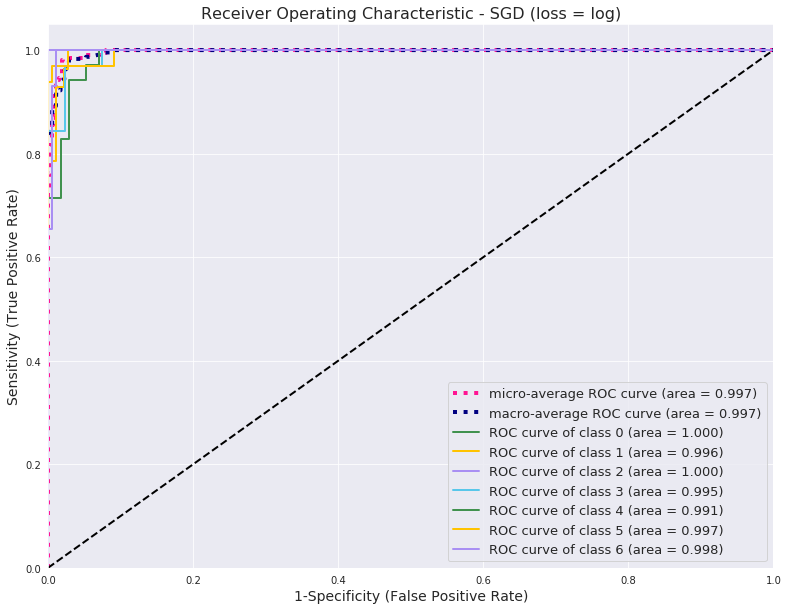

In [16]:
#Binarize the labels
from sklearn.preprocessing import label_binarize
'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
y_b = label_binarize(y, classes = [0, 1, 2, 3, 4, 5, 6])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix - SGD

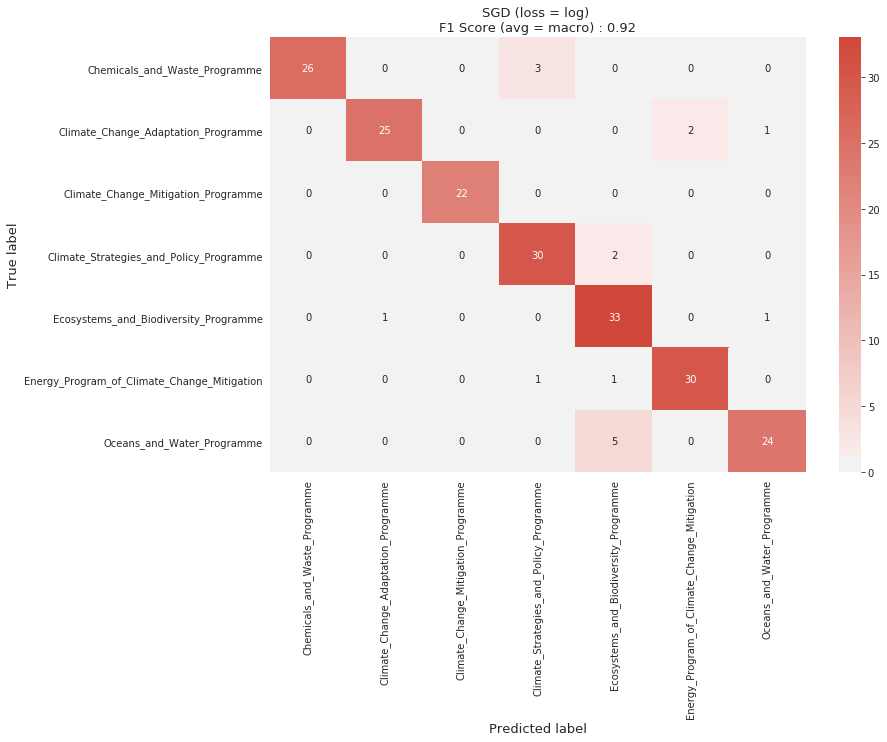

In [17]:
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'], 
                     columns = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Plot AUC - RF

/home/oumaima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


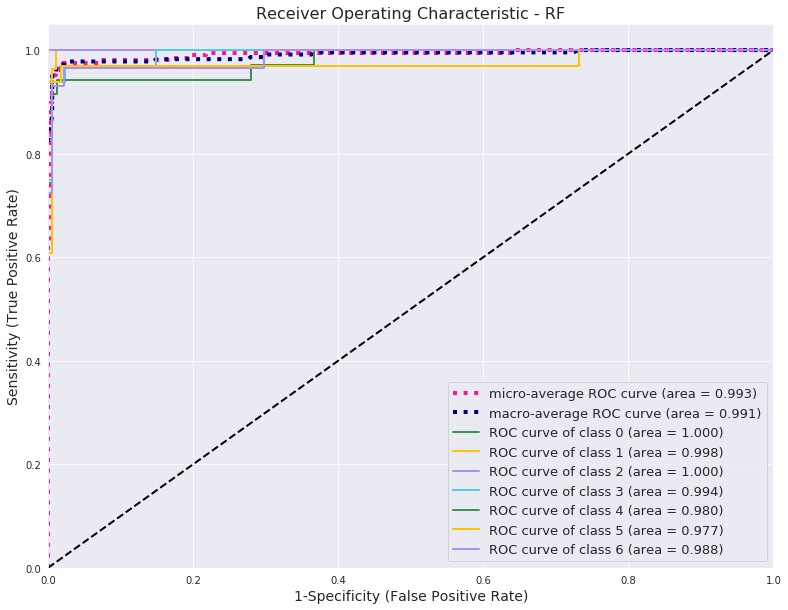

In [18]:
#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix - RF

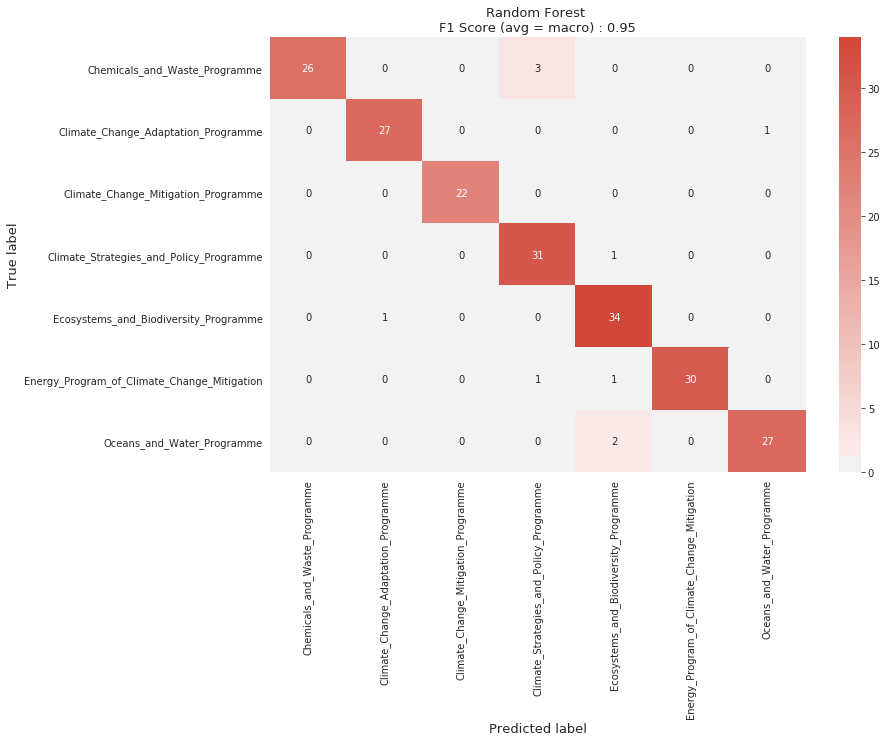

In [19]:
#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'], 
                     columns = ['Chemicals_and_Waste_Programme', 'Climate_Change_Adaptation_Programme',
       'Climate_Change_Mitigation_Programme',
       'Climate_Strategies_and_Policy_Programme',
       'Ecosystems_and_Biodiversity_Programme',
       'Energy_Program_of_Climate_Change_Mitigation',
       'Oceans_and_Water_Programme'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Putting it all together to make predictions on the unseen text

In [21]:
#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['all_text_clean'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Chemicals_and_Waste_Programme': 0,
                  'Climate_Change_Adaptation_Programme': 1,
                  'Climate_Change_Mitigation_Programme': 2,
                  'Climate_Strategies_and_Policy_Programme': 3,
                 'Ecosystems_and_Biodiversity_Programme': 4,
                 'Energy_Program_of_Climate_Change_Mitigation': 5,
                 'Oceans_and_Water_Programme': 6}
l = []
for i in df_holdout['technical_team']:
    for s in i:
        l.append(s)
#df_holdout['technical_team']  = l 
print (len(l))
print (len(df_holdout['technical_team'].tolist()))
df_holdout['correct'] = df_holdout['technical_team'].map(label_num_dict)
df_holdout = pd.DataFrame(df_holdout, columns = ['all_text_clean', 'technical_team', 'pred_sgd', 'pred_rf', 'correct'])

df_holdout

1220
35


,all_text_clean,technical_team,pred_sgd,pred_rf,correct
149,protect human health and the environment from ...,Chemicals_and_Waste_Programme,0,0,0
426,to accelerate hcfc phaseout to achieve the com...,Chemicals_and_Waste_Programme,0,0,0
427,project description worldwide artisanal and sm...,Chemicals_and_Waste_Programme,0,0,0
61,persistent organic pollutants pops are chemica...,Chemicals_and_Waste_Programme,0,0,0
426,to accelerate hcfc phaseout to achieve the com...,Chemicals_and_Waste_Programme,0,0,0
19,to strengthen the protection of vulnerable gui...,Climate_Change_Adaptation_Programme,1,1,1
53,kiribati is a nation comprised of atolls inhab...,Climate_Change_Adaptation_Programme,1,1,1
54,tuvalu is one of the most vulnerable countries...,Climate_Change_Adaptation_Programme,1,1,1
57,as climate change evolves and floods and droug...,Climate_Change_Adaptation_Programme,1,1,1
72,são tomé and príncipe stp is vulnerable to cli...,Climate_Change_Adaptation_Programme,1,1,1


In [36]:
with open('./encoded_labels/technical_team.pkl', 'rb') as handle:
    df = pickle.load(handle)
          
#Holding out 5 rows from the original dataframe for prediction at the end
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [37]:
#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['all_text_clean'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Chemicals_and_Waste_Programme': 0,
                  'Climate_Change_Adaptation_Programme': 1,
                  'Climate_Change_Mitigation_Programme': 2,
                  'Climate_Strategies_and_Policy_Programme': 3,
                 'Ecosystems_and_Biodiversity_Programme': 4,
                 'Energy_Program_of_Climate_Change_Mitigation': 5,
                 'Oceans_and_Water_Programme': 6}
l = []
for i in df_holdout['technical_team']:
    for s in i:
        l.append(s)
df_holdout['technical_team']  = l 
df_holdout['correct'] = df_holdout['technical_team'].map(label_num_dict)
df_holdout = pd.DataFrame(df_holdout, columns = ['all_text_clean', 'technical_team', 'pred_sgd', 'pred_rf', 'correct'])

df_holdout

,all_text_clean,technical_team,pred_sgd,pred_rf,correct
0,this programme will contribute to the protecti...,Ecosystems_and_Biodiversity_Programme,4,4,4
1,the project contributes to the number of gef p...,Ecosystems_and_Biodiversity_Programme,4,4,4
2,the cape floristic region cfr biodiversity hot...,Ecosystems_and_Biodiversity_Programme,4,4,4
3,the niger delta region of nigeria covering an ...,Ecosystems_and_Biodiversity_Programme,4,4,4
4,the government of south africa has developed t...,Ecosystems_and_Biodiversity_Programme,4,4,4


# Way better results !!!